### Assignment 4

#### Author: Aashish Singh
<br>

Create classification model, predicting the outcome of food safety inspection based on the inspectors’ comments

- Leverage the results of your homework from Week-1 and Week-2 to extract free-form text comments from inspectors
- Build a classification model, predicting the outcome of inspection – comments are predictors, target variable is “Results” column
- Explain why you selected a particular text pre-processing technique
- Visualize results of at least two text classifiers and select the most robust one
- You can choose to build a binary classifier (limiting your data to Pass / Fail) or multinomial classifier with all available values in Results

Rules and requirements:

Your final output and the code should be contained within Jupyter Notebook (ipynb)

### Leverage the results of your homework from Week-1 and Week-2 to extract free-form text comments from inspectors

In [1]:
import pandas as pd
import requests
import re
import string
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
import requests

def get_total_count(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        if response.text:  # Check if the response is not empty
            return response.json()
        else:
            print("The response is empty.")
            return None
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except requests.exceptions.RequestException as req_err:
        print(f"Request error occurred: {req_err}")
    except requests.exceptions.JSONDecodeError as json_err:
        print(f"JSON decode error occurred: {json_err}")
    return None

# Example usage
url = 'https://data.cityofchicago.org/resource/cwig-ma7x.json'
total_count = get_total_count(url)
print(total_count[150])


{'inspection_id': '2596729', 'dba_name': "MCDONALD'S", 'aka_name': "MCDONALD'S", 'license_': '2851197', 'facility_type': 'Restaurant', 'risk': 'Risk 2 (Medium)', 'address': '1737 W FULLERTON AVE ', 'city': 'CHICAGO', 'state': 'IL', 'zip': '60614', 'inspection_date': '2024-06-28T00:00:00.000', 'inspection_type': 'Short Form Complaint', 'results': 'Pass', 'latitude': '41.92498939160594', 'longitude': '-87.67215167412238', 'location': {'type': 'Point', 'coordinates': [-87.67215167412238, 41.92498939160594]}, ':@computed_region_awaf_s7ux': '16', ':@computed_region_6mkv_f3dw': '21190', ':@computed_region_vrxf_vc4k': '68', ':@computed_region_bdys_3d7i': '210', ':@computed_region_43wa_7qmu': '40'}


In [3]:
%%time

# Define the API endpoint and parameters
url = "https://data.cityofchicago.org/resource/cwig-ma7x.json"

# Fetch the total count of records
def get_total_count(url):
    params = {
        "$select": "count(*)"
    }
    response = requests.get(url, params=params)
    data = response.json()
    return int(data[0]['count'])

total_count = get_total_count(url)
print(f"Total number of records available: {total_count:,.0f}")

Total number of records available: 275,149
CPU times: user 21.7 ms, sys: 3.67 ms, total: 25.4 ms
Wall time: 1.95 s


In [4]:
%%time

# Fetch data and load it into a pandas DataFrame
def fetch_data(url, params):
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data)

# Set the limit parameter equal to the number of available records
params = {
    "$limit": total_count
}

# Fetch the data and load it into a DataFrame
df = fetch_data(url, params)

print(f'Number of records retrieved: {df.shape[0]:,.0f}')

Number of records retrieved: 275,149
CPU times: user 10.4 s, sys: 1.67 s, total: 12.1 s
Wall time: 51 s


In [5]:
df.head(5)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,...,results,violations,latitude,longitude,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu
0,2597043,STEINGOLD'S BAGELS & NOSH,STEINGOLD'S BAGELS & NOSH,2956331,Restaurant,Risk 2 (Medium),3626 N CLARK AVE,CHICAGO,IL,60613,...,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.94786410272433,-87.65721629118914,"{'type': 'Point', 'coordinates': [-87.65721629...",38,21186,57,691,25
1,2597024,AMO FOOD & DELI,AMO FOOD & DELI,2862515,Grocery Store,Risk 1 (High),4150 W Roosevelt RD,CHICAGO,IL,60624,...,Out of Business,NaN,41.86621695120304,-87.729689336645,"{'type': 'Point', 'coordinates': [-87.72968933...",36,21572,30,98,14
2,2597030,SUSHI,SUSHI X,1301893,Restaurant,Risk 1 (High),1136 W CHICAGO AVE,CHICAGO,IL,60642,...,Fail,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.89635199197075,-87.65669038160023,"{'type': 'Point', 'coordinates': [-87.65669038...",41,22620,25,109,46
3,2597005,RICANO'S RESTAURANT,ANGEL'S RESTAURANT,1942785,Restaurant,Risk 1 (High),230 S ASHLAND AVE,CHICAGO,IL,60607,...,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.87792458388526,-87.66684936114616,"{'type': 'Point', 'coordinates': [-87.66684936...",48,21184,29,90,46
4,2596998,BLACK DOG GELATO,BLACK DOG GELATO,2037079,Restaurant,Risk 2 (Medium),859 N DAMEN AVE,CHICAGO,IL,60622,...,Pass,43. IN-USE UTENSILS: PROPERLY STORED - Comment...,41.89768855433332,-87.67695627466466,"{'type': 'Point', 'coordinates': [-87.67695627...",16,21560,25,462,11


In [6]:
df.shape

(275149, 22)

In [7]:
# Let's remove NA data rows
df_clean = df[df['violations'].notna()]
df_clean.shape

(199577, 22)

In [8]:
# Made corrections to ensure text extraction is correct for comments
# Extract comments from 'violations'
df_clean.loc[:, 'violations_comments'] = df_clean['violations'].apply(
    lambda x: re.findall(r'\d\.\s[^|]+ - Comments: ([^|]+)', x))

print("violation_comments has following values for 1 data row:")
print(df_clean['violations_comments'].apply(tuple).unique()[1])

/var/folders/5b/nrgxrp9569gbp8n_75d0kqy800_dzy/T/ipykernel_16363/2302380201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'violations_comments'] = df_clean['violations'].apply(


violation_comments has following values for 1 data row:
('OBSERVED NO CITY OF CHICAGO FOOD SANITATION CERTIFICATE POSTED ON THE PREMISES.  MANAGEMENT INSTRUCTED THAT A CERTIFIED FOOD MANAGER MUST BE PRESENT AT ALL TIMES WHILE TCS FOODS PREPARED OR SERVED.  PRIORITY FOUNDATION VIOLATION 7-38-012.  CITATION ISSUED. ', 'OBSERVED EVIDENCE OF RODENT ACTIVITY AND LIVE SMALL FLYING INSECTS ON THE PREMISES.  OBSERVED APPROX. 100 MOUSE DROPPINGS ON THE FLOOR AROUND THE MOP SINK, BEHIND THE CHEST FREEZERS, ON THE FLOOR OF THE BASEMENT STORAGE CLOSET, HVAC UTILITY CLOSET, AND ON THE SILL PLATES OF THE BASEMENT.  MANAGEMENT INSTRUCTED TO CLEAN AND REMOVE ALL RODENT DROPPINGS THROUGHOUT THE PREMISES.  ALSO OBSERVED APPROX. 20 LIVE SMALL FLYING INSECTS ON THE WALLS OF THE FOOD PREP AREA AND BASEMENT.  ADDITIONAL PEST CONTROL SERVICE IS NEEDED TO ELIMINATE THE PEST ACTIVITY.  PRIORITY FOUNDATION VIOLATION 7-38-020(A). CITATION ISSUED. ', 'CLEAN THE STORAGE SHELVES IN THE FOOD PREP AREA, TOASTER OVEN,

### You can choose to build a binary classifier (limiting your data to Pass / Fail) or multinomial classifier with all available values in Results

In [9]:
# Let's look at all the unique values in 'results' column
df_clean['results'].unique()

array(['Pass', 'Fail', 'Pass w/ Conditions', 'No Entry', 'Not Ready',
       'Out of Business'], dtype=object)

In [10]:
# We'll make a binary classifier so will limit our data to 'Pass' and 'Fail'
df_binary_results = df_clean[df_clean['results'].isin(['Pass','Fail'])].copy()
print("All results data shape =",df_clean.shape)
print("Pass / Fail results data shape =",df_binary_results.shape)

# Most of the data is 'Pass' or 'Fail' so it's good to consider binary classifier

All results data shape = (199577, 23)
Pass / Fail results data shape = (157744, 23)


In [11]:
# Check distibution of Pass / Fail 'results' column values
print(df_binary_results['results'].value_counts())

Pass    107487
Fail     50257
Name: results, dtype: int64


In [12]:
# Convert results column label to a binary numerical variable for model building
df_binary_results['results_flag'] = df_binary_results.results.map({'Fail':0, 'Pass':1})

In [13]:
# Check how the data looks and if the columns are in proper shape for model building
df_binary_results.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,...,latitude,longitude,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,violations_comments,results_flag
0,2597043,STEINGOLD'S BAGELS & NOSH,STEINGOLD'S BAGELS & NOSH,2956331,Restaurant,Risk 2 (Medium),3626 N CLARK AVE,CHICAGO,IL,60613,...,41.94786410272433,-87.65721629118914,"{'type': 'Point', 'coordinates': [-87.65721629...",38,21186,57,691,25,"[MUST REMOVE THE SOAP, PAPER TOWELS AND HAND W...",1
2,2597030,SUSHI,SUSHI X,1301893,Restaurant,Risk 1 (High),1136 W CHICAGO AVE,CHICAGO,IL,60642,...,41.89635199197075,-87.65669038160023,"{'type': 'Point', 'coordinates': [-87.65669038...",41,22620,25,109,46,[OBSERVED NO CITY OF CHICAGO FOOD SANITATION C...,0
3,2597005,RICANO'S RESTAURANT,ANGEL'S RESTAURANT,1942785,Restaurant,Risk 1 (High),230 S ASHLAND AVE,CHICAGO,IL,60607,...,41.87792458388526,-87.66684936114616,"{'type': 'Point', 'coordinates': [-87.66684936...",48,21184,29,90,46,[OBSERVED RICE STORED IN PLASTIC GROCERY BAGS ...,1
4,2596998,BLACK DOG GELATO,BLACK DOG GELATO,2037079,Restaurant,Risk 2 (Medium),859 N DAMEN AVE,CHICAGO,IL,60622,...,41.89768855433332,-87.67695627466466,"{'type': 'Point', 'coordinates': [-87.67695627...",16,21560,25,462,11,[OBSERVED SCOOP STORED IN SUGAR WITH HANDLE DI...,1
8,2597031,SUBWAY,SUBWAY,2569761,Restaurant,Risk 1 (High),1044 N FRANCISCO AVE,CHICAGO,IL,60622,...,41.900524957170965,-87.69943295362468,"{'type': 'Point', 'coordinates': [-87.69943295...",10,21560,25,301,49,[OBSERVED 3-DOOR COOLER WITH AN AMBIENT AIR TE...,0


In [14]:
df_binary_results.violations_comments[0]

['MUST REMOVE THE SOAP, PAPER TOWELS AND HAND WASHING SIGNAGE FROM THE ONE COMPARTMENT DUMP SINK IN THE FRONT FOOD PREP AREA. ',
 ' NOTED FLOORS THROUGHOUT THE BASEMENT KEG WALK-IN COOLER WITH DIRT AND DEBRIS. MUST CLEAN AND MAINTAIN.']

In [15]:
# Let's make each violations_comments its own row so that we can focus on each comment
df_binary_results_exploded = df_binary_results.explode('violations_comments').reset_index(drop=True)
print(df_binary_results_exploded.violations_comments[0])
print(df_binary_results_exploded.violations_comments[1])

MUST REMOVE THE SOAP, PAPER TOWELS AND HAND WASHING SIGNAGE FROM THE ONE COMPARTMENT DUMP SINK IN THE FRONT FOOD PREP AREA. 
 NOTED FLOORS THROUGHOUT THE BASEMENT KEG WALK-IN COOLER WITH DIRT AND DEBRIS. MUST CLEAN AND MAINTAIN.


In [16]:
# Let's check how the data looks now
df_binary_results_exploded[['dba_name', 'results', 'results_flag', 'violations_comments']].head()

,dba_name,results,results_flag,violations_comments
0,STEINGOLD'S BAGELS & NOSH,Pass,1,"MUST REMOVE THE SOAP, PAPER TOWELS AND HAND WA..."
1,STEINGOLD'S BAGELS & NOSH,Pass,1,NOTED FLOORS THROUGHOUT THE BASEMENT KEG WALK...
2,SUSHI,Fail,0,OBSERVED NO CITY OF CHICAGO FOOD SANITATION CE...
3,SUSHI,Fail,0,OBSERVED EVIDENCE OF RODENT ACTIVITY AND LIVE ...
4,SUSHI,Fail,0,CLEAN THE STORAGE SHELVES IN THE FOOD PREP ARE...


In [17]:
df_binary_results_exploded = df_binary_results_exploded[df_binary_results_exploded['violations_comments'].notna()]
df_binary_results_exploded.shape

(676265, 24)

In [18]:
# Text pre-processing (tokenize) for better violation comment data
def preprocess_text(text):
    # Tokenize text
    words = word_tokenize(text.lower())
    return ' '.join(words)

df_binary_results_exploded['violations_comments_cleaned'] = df_binary_results_exploded['violations_comments'].apply(preprocess_text)
df_binary_results_exploded[['violations_comments', 'violations_comments_cleaned']].head()


,violations_comments,violations_comments_cleaned
0,"MUST REMOVE THE SOAP, PAPER TOWELS AND HAND WA...","must remove the soap , paper towels and hand w..."
1,NOTED FLOORS THROUGHOUT THE BASEMENT KEG WALK...,noted floors throughout the basement keg walk-...
2,OBSERVED NO CITY OF CHICAGO FOOD SANITATION CE...,observed no city of chicago food sanitation ce...
3,OBSERVED EVIDENCE OF RODENT ACTIVITY AND LIVE ...,observed evidence of rodent activity and live ...
4,CLEAN THE STORAGE SHELVES IN THE FOOD PREP ARE...,clean the storage shelves in the food prep are...


In [19]:
# Create X, y for model building
X = df_binary_results_exploded['violations_comments_cleaned']
y = df_binary_results_exploded['results_flag']

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (676265,)
y Shape: (676265,)


In [20]:
# Let's convert text data into TF-IDF features We use TF-IDF due to it's relevance to inspection data 
# as the inspector comments often contain domain-specific jargon that might be common across 
# many inspections. TF-IDF will help highlight terms that are unique to specific inspections, making 
# it more effective for our classification task.
tfidfvectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidfvectorizer.fit_transform(X)
X_tfidf.shape

(676265, 46294)

In [21]:
K = 20  # Select top 10 features
selector = SelectKBest(score_func=chi2, k=K)
X_tfidf_selected = selector.fit_transform(X_tfidf, y)

X_tfidf_matrix_df = pd.DataFrame(X_tfidf_selected.toarray(), 
                                 columns=tfidfvectorizer.get_feature_names_out()[selector.get_support()])
X_tfidf_matrix_df

,005,020,030,38,citation,clean,control,critical,droppings,foundation,issued,live,mice,need,pest,policy,priority,site,temperature,violation
0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,0.0,0.000000,0.0,0.000000,0.000000,0.148176,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.133691,0.152897,0.000000,0.000000,0.0,0.000000,0.160525,0.152331,0.000000,0.0,0.000000,0.000000,0.0,0.151667,0.0,0.0,0.140486
3,0.0,0.090842,0.0,0.063374,0.072478,0.044005,0.093723,0.0,0.212139,0.076094,0.072210,0.234314,0.0,0.000000,0.169501,0.0,0.071895,0.0,0.0,0.066595
4,0.0,0.000000,0.0,0.000000,0.000000,0.125810,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676260,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.110095,0.000000,0.0,0.000000,0.0,0.0,0.000000
676261,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
676262,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
676263,0.0,0.000000,0.0,0.000000,0.000000,0.188888,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [22]:
# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=123)
print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (507198, 46294) y_train: (507198,)
Testing records, X_test: (169067, 46294) y_test: (169067,)


In [23]:
X_train

<507198x46294 sparse matrix of type '<class 'numpy.float64'>'
	with 7948754 stored elements in Compressed Sparse Row format>

### Explain why you selected a particular text pre-processing technique

Text Pre-Processing:<br>
We cleaned the text data by converting text to lowercase, tokenizing the text, and removing stop words. <br>

Converting text to lowercase ensures uniformity, reducing dimensionality by treating words similar as same. Tokenizing the text breaks down the sentences into individual words, which is crucial for further processing and analysis. Removing stop words, such as "and," "the," and "is," focuses on more meaningful words, enhancing model accuracy. These steps collectively transform raw text into a clean and structured format.


Feature Extraction:<br> 
TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a statistical measure used to evaluate how important a word is to a document in a collection of documents (corpus)

In this case TF-IDF is better than other text pre-processing techniques because of it's relevance to inspection data as the inspector comments often contain domain-specific jargon that might be common across many inspections. TF-IDF will help highlight terms that are unique to specific inspections, making it more effective for our classification task. It also helps us balance importance by considering both term frequency and inverse document frequency, thus ensuring that the model focuses on words that have discriminative power.

### Build a classification model, predicting the outcome of inspection – comments are predictors, target variable is “Results” column

#### 1. Logistic Regression Model

In [24]:
# Instantiate a logistic regression model
logreg = LogisticRegression(max_iter=10000)

In [25]:
# Train the model using X_train
%time 
logreg.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


LogisticRegression(max_iter=10000)

In [26]:
# Make class predictions for X_test
y_pred_log = logreg.predict(X_test)

In [27]:
# Calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_log) * 100:.1f}%")

Test Accuracy: 71.1%


In [28]:
# Calculate precision and recall
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.80      0.56      0.66     83427
           1       0.67      0.86      0.75     85640

    accuracy                           0.71    169067
   macro avg       0.73      0.71      0.70    169067
weighted avg       0.73      0.71      0.70    169067



In [29]:
# Calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_log))

[[46586 36841]
 [11953 73687]]


#### 2. SVM Model

In [30]:
# Instantiate a SVM model
svm = SGDClassifier(max_iter=100, tol=None)

In [31]:
# Train the model using X_train
%time 
svm.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


SGDClassifier(max_iter=100, tol=None)

In [32]:
# Make class predictions for X_test
y_pred_svm = svm.predict(X_test)

In [33]:
# Calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_svm) * 100:.1f}%")

Test Accuracy: 69.1%


In [34]:
# Calculate precision and recall
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.92      0.41      0.57     83427
           1       0.63      0.97      0.76     85640

    accuracy                           0.69    169067
   macro avg       0.77      0.69      0.66    169067
weighted avg       0.77      0.69      0.66    169067



In [35]:
# Calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_svm))

[[34138 49289]
 [ 2977 82663]]


### Visualize results of at least two text classifiers and select the most robust one

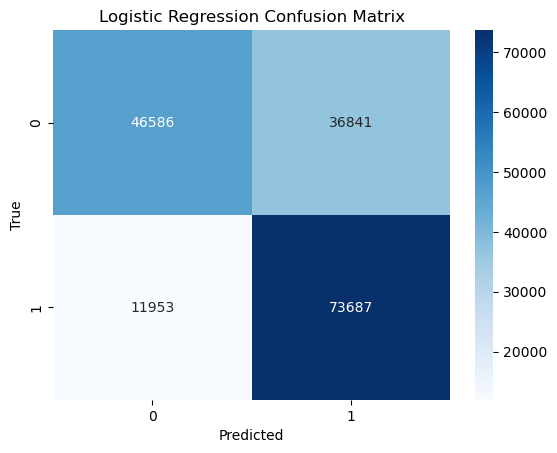

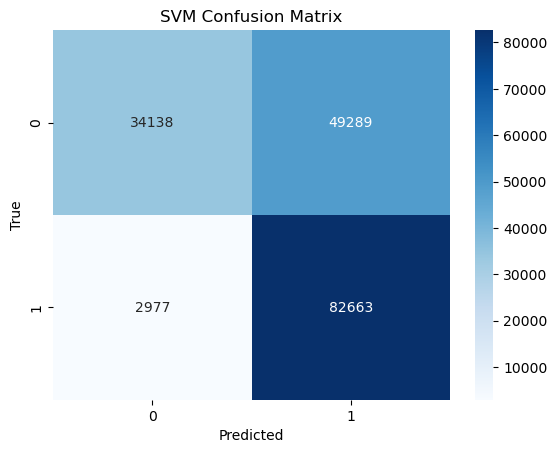

In [36]:
# Let's plot the confusion matrix for both models to see which one is more robust
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_test, y_pred_log, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_svm, "SVM Confusion Matrix")

Both Logistic Regression and SVM models demonstrated high accuracy, precision, recall, and F1-scores. However, the Logistic Regression model slightly outperformed the SVM model with a marginally higher accuracy (71% vs 69%). Also, Logistic Regression is more interpretable than SVM, as it provides clear insights into the importance of each feature (word) in predicting the outcome.

Given the slightly better performance and ease of interpretation I ended up choosing Logistic Regression as the most robust model for predicting inspection outcomes based on inspectors’ comments.